In [1]:
import dlc_bci as bci

In [2]:
import torch
from torch import cuda , nn , optim
from torch.optim import lr_scheduler 
from torch.nn import functional as F 
from torch.autograd import Variable 

In [3]:
torch.__version__

'0.3.1.post2'

In [31]:
import numpy as np
from sklearn import svm 

In [44]:
train_input, train_target = bci.load(root='./data_bci')
test_input, test_target = bci.load(root='./data_bci', train=False)
print(str(type(train_input)), train_input.size()) 
print(str(type(train_target)), train_target.size())
print(str(type(test_input)), test_input.size()) 
print(str(type(test_target)), test_target.size())

<class 'torch.FloatTensor'> torch.Size([316, 28, 50])
<class 'torch.LongTensor'> torch.Size([316])
<class 'torch.FloatTensor'> torch.Size([100, 28, 50])
<class 'torch.LongTensor'> torch.Size([100])


In [45]:
train_input.shape

torch.Size([316, 28, 50])

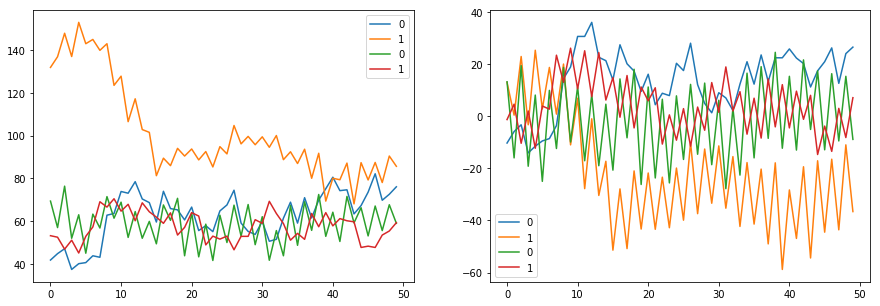

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(range(50),np.array(train_input[0,0]))
ax[0].plot(range(50),np.array(train_input[1,0]))
ax[0].plot(range(50),np.array(train_input[2,0]))
ax[0].plot(range(50),np.array(train_input[3,0]))
ax[0].legend(train_target[:4])
ax[1].plot(range(50),np.array(train_input[0,1]))
ax[1].plot(range(50),np.array(train_input[1,1]))
ax[1].plot(range(50),np.array(train_input[2,1]))
ax[1].plot(range(50),np.array(train_input[3,1]))
ax[1].legend(train_target[:4])

In [8]:
# TODO: Randomly choose train and test set #

In [9]:
train_input.

SyntaxError: invalid syntax (<ipython-input-9-74068041f9ec>, line 1)

In [ ]:
# Normalization
mu, std = train_input.mean(), train_input.std()
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)
# convert to Variable
train_input, train_target = Variable(train_input), Variable(train_target)
test_input, test_target = Variable(test_input), Variable(test_target)

#### data augmentation


In [47]:
from scipy import signal

In [48]:
def sampling(data,start,step):
    length = data.size()[2]
    sample = set(range(0,length,step))
    rest = set(range(length))
    data_ind = list(rest.difference(sample))
    return data_ind

In [49]:
def interpolation(data,data_len,start):
    x,y,z = data.size()
    data_new = np.zeros((x,y,data_len))
    data_ind = sampling(data,start,8)
    data = data[:,:,data_ind]
    for i in range(x):
        for j in range(y):
            data_new[i,j] = signal.resample(data[i,j],data_len)
    return data_new

In [50]:
data_resample = interpolation(train_input,50,0)

In [51]:
train_input_new = np.concatenate((np.array(train_input),data_resample[0:200]),axis = 0)
train_input_new = torch.Tensor(train_input_new)

In [52]:
train_target_new = np.concatenate((np.array(train_target),np.array(train_target[0:200])),axis=0)
train_target_new = torch.LongTensor(train_target_new)

In [53]:
# Normalization
mu, std = train_input_new.mean(), train_input_new.std()
train_input_new.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)
# convert to Variable
train_input, train_target = Variable(train_input_new), Variable(train_target_new)
test_input, test_target = Variable(test_input), Variable(test_target)

## Support Vector Machine -- Baseline

In [54]:
X_train = train_input.view(516,-1)
y_train = train_target
X_test = test_input.view(100,-1)
y_test = test_target

In [56]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train.data, y_train.data)
clf.score(X_test.data, y_test.data)

0.67

# Neural Network

In [17]:
## OLD
#train_input = train_input.view(316,1,50,28)
#test_input = test_input.view(100,1,50,28)

In [18]:
'''
class Net_OLD(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 30, kernel_size=(7,1))
        self.conv1_drop = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(30, 10, kernel_size=(5,5))
        self.conv2_drop = nn.Dropout(0.3)
        self.conv3 = nn.Conv2d(10, 5, kernel_size=(1,1))
        self.conv3_drop = nn.Dropout(0.3)
        self.fc1 = nn.Linear(1200,120)
        self.fc1_drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(120,100)
        self.fc2_drop = nn.Dropout(0.3)
        self.fc3 = nn.Linear(100,2)
    def forward(self, x): 
        x = F.relu(self.conv1(x))
        x = self.conv1_drop(x)
        x = F.relu(self.conv2(x))
        x = self.conv2_drop(x)
        x = F.relu(self.conv3(x))
        x = self.conv3_drop(x)
        
        x = F.max_pool2d(x, (2,2))
        
        x = x.view(x.size(0),-1)
       
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        x = F.relu(self.fc3(x))
        return x
'''

'\nclass Net_OLD(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.conv1 = nn.Conv2d(1, 30, kernel_size=(7,1))\n        self.conv1_drop = nn.Dropout(0.3)\n        self.conv2 = nn.Conv2d(30, 10, kernel_size=(5,5))\n        self.conv2_drop = nn.Dropout(0.3)\n        self.conv3 = nn.Conv2d(10, 5, kernel_size=(1,1))\n        self.conv3_drop = nn.Dropout(0.3)\n        self.fc1 = nn.Linear(1200,120)\n        self.fc1_drop = nn.Dropout(0.3)\n        self.fc2 = nn.Linear(120,100)\n        self.fc2_drop = nn.Dropout(0.3)\n        self.fc3 = nn.Linear(100,2)\n    def forward(self, x): \n        x = F.relu(self.conv1(x))\n        x = self.conv1_drop(x)\n        x = F.relu(self.conv2(x))\n        x = self.conv2_drop(x)\n        x = F.relu(self.conv3(x))\n        x = self.conv3_drop(x)\n        \n        x = F.max_pool2d(x, (2,2))\n        \n        x = x.view(x.size(0),-1)\n       \n        x = F.relu(self.fc1(x))\n        x = self.fc1_drop(x)\n        x = F.r

In [121]:
train_input = train_input.view(516,28,50)
test_input = test_input.view(100,28,50)

In [300]:
class Net_1D(nn.Module):
    def __init__(self):
        super(Net_1D, self).__init__()
        
        self.conv1 = nn.Conv1d(28, 50, kernel_size=4)
        self.conv1_bn = nn.BatchNorm1d(50)
        self.conv1_drop = nn.Dropout(0.5)
        
        self.conv2 = nn.Conv1d(50, 110, kernel_size=4)
        self.conv2_bn = nn.BatchNorm1d(110)    
        self.conv2_drop = nn.Dropout(0.5)       
        
        self.fc1 = nn.Linear(1100,500)
        self.fc1_bn = nn.BatchNorm1d(500)
        self.fc1_drop = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(500,200)
        self.fc2_bn = nn.BatchNorm1d(200)
        self.fc2_drop = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(200,40)
        self.fc3_bn = nn.BatchNorm1d(40)
        self.fc3_drop = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(40,40)
        self.fc4_bn = nn.BatchNorm1d(40)
        self.fc4_drop = nn.Dropout(0.5)
        
        self.fc5 = nn.Linear(40,40)
        self.fc5_bn = nn.BatchNorm1d(40)
        self.fc5_drop = nn.Dropout(0.5)
        
        self.fc6 = nn.Linear(40,2)
        
    def forward(self, x): 
        
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.max_pool1d(x, 2)
        x = self.conv1_drop(x)

        
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.max_pool1d(x, 2)
        x = self.conv2_drop(x)
                
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.fc1_drop(x)
        
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc2_drop(x)
        
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = self.fc3_drop(x)
        
        x1 = x
        
        x = F.relu(self.fc4_bn(self.fc4(x)))
        x = self.fc4_drop(x)
        
        x = F.relu(self.fc5_bn(self.fc5(x)))
        #x = self.fc4_drop(x)
        
        x = F.softmax(self.fc6(x+x1), 1)
        return x

In [301]:
# test the structure
model = Net_1D()
print(model(train_input).shape)

torch.Size([516, 2])


In [302]:
def train_model(model, train_input, train_target):
    lr, nb_epochs = 1e-3, 200
    #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-2) # lr=1e-1
    #optimizer = optim.Adadelta(model.parameters(), lr=lr, weight_decay=1e-3) # lr=1e-1
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.8) # lr=1e-3
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience = 20,factor = 0.01,threshold = 1e-4,eps  = 1e-9)
    #scheduler = lr_scheduler.StepLR(optimizer, step_size=75, gamma=0.5)
    criterion = torch.nn.CrossEntropyLoss()
    errors = []
    losses = []
    error = np.inf
    count = 0
    lo = 1000
    count = 0
    for k in range(nb_epochs):
        scheduler.step(error)
        optimizer.zero_grad()
        model_train = model.train() 
        output = model_train(train_input)
        loss = criterion(output, train_target)
        loss.backward()
        optimizer.step()
        
        pred = output.data.max(1, keepdim=True)[1]
        error = pred.ne(train_target.data.view_as(pred)).sum()
        if lo < error and k > 30:
            if  error- lo> 5:
                count +=1
                if count > 2:
                    break
        else:
            count = 0
        lo = np.copy(error)
        if k%10==0 : print(k, error, loss.data[0])
        errors.append(error)
        losses.append(loss.data[0])
    return errors, losses

In [303]:
def compute_nb_errors(model, data_input, data_target):
    nb_data_errors = 0
    model_eval = model.eval()
    output = model_eval(test_input)
    _, predicted_classes = torch.max(output,1)
    for k in range(len(data_target)):
        if data_target.data[k] != predicted_classes.data[k]:
            nb_data_errors = nb_data_errors + 1
    return nb_data_errors

In [ ]:
model = Net_1D()

errors, losses = train_model(model, train_input, train_target)

fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)
ax[0].plot(np.array(errors)/train_input.size(0))
ax[0].set_title("Error Rate")
ax[0].grid()
ax[1].plot(np.array(losses))
ax[1].set_title("Loss")
ax[1].grid()
plt.show();

nb_error = compute_nb_errors(model, test_input, test_target)
print('Correct: {:.2%}'.format(1-nb_error/test_input.size(0)))

0 236 0.692949116230011
10 256 0.6995791792869568
20 263 0.7029575705528259
30 242 0.6934931874275208
40 253 0.6937456130981445
50 251 0.6921370625495911


In [107]:
nb_error = compute_nb_errors(model, test_input, test_target)
print('Correct: {:.2%}'.format(1-nb_error/test_input.size(0)))

Correct: 73.00%


# LSTM - Unfinished Overfitting

In [109]:
for std in [ -1, 1e-10, 1e-7]:

        model = Net_1D() 

        if std > 0:
            for p in model.parameters(): p.data.normal_(0, std)

        errors, losses = train_model(model, train_input, train_target)

        print('std {:s} {:f} train_error {:.02f}% test_error {:.02f}%'.format(
            Net_1D.__name__,
            std,
            errors[-1] / train_input.size(0) * 100,
            compute_nb_errors(model, test_input, test_target) / test_input.size(0) * 100
        )
        )

0 151 0.6900094151496887
10 161 0.6957911849021912
20 155 0.6968663930892944
30 152 0.6975080370903015
40 140 0.6841146349906921
50 128 0.677240252494812
60 123 0.6722509264945984
70 88 0.6537157893180847
80 81 0.6321089267730713
90 86 0.6268705725669861
100 84 0.6333219408988953
110 63 0.6073801517486572
120 75 0.6035564541816711
130 62 0.5957669019699097
140 65 0.5935502648353577
std Net_1D -1.000000 train_error 18.04% test_error 25.00%
0 157 0.6931460499763489
10 157 0.6931467652320862
20 157 0.6931428909301758
30 157 0.6931436657905579
40 157 0.6931454539299011
50 157 0.6931423544883728
60 157 0.6931424140930176
70 157 0.6931421756744385
80 157 0.6931421756744385
90 157 0.6931421756744385
100 157 0.6931421756744385
110 157 0.6931421756744385
120 157 0.6931421756744385
130 157 0.6931421756744385
140 157 0.6931421756744385
std Net_1D 0.000000 train_error 49.68% test_error 51.00%
0 159 0.6931459903717041
10 157 0.6931467056274414
20 157 0.6931429505348206
30 157 0.6931425333023071
40 

In [17]:
train_input = train_input.view(316,50,28)
test_input = test_input.view(100,50,28)

In [18]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=28,
            hidden_size=10,         # rnn hidden unit
            num_layers=2,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            dropout=0.5,
        )
        self.bn  = nn.BatchNorm2d(10)
        self.out = nn.Linear(10, 2)
        
    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = F.softmax(self.out(self.bn(r_out[:, -1, :])), 1)
        return out

In [19]:
# test the structure
model = RNN()
print(model(train_input).shape)

torch.Size([316, 2])


In [20]:
def train_model(model, train_input, train_target):
    lr, nb_epochs = 1e-2, 200
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-3)

    scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    
    criterion = torch.nn.CrossEntropyLoss()
    errors = []
    losses = []
    for k in range(nb_epochs):
        scheduler.step()
        
        optimizer.zero_grad()
        output = model.train(train_input) 
        loss = criterion(output, train_target)
        loss.backward()
        optimizer.step()
        
        pred = output.data.max(1, keepdim=True)[1]
        error = pred.ne(train_target.data.view_as(pred)).sum()
        if k%10==0 : print(k, error, loss.data[0])
        errors.append(error)
        losses.append(loss.data[0])
    return errors, losses

0 164 0.7039636969566345
10 151 0.6876636743545532
20 147 0.6876260042190552
30 122 0.6588642597198486
40 128 0.6552749872207642
50 122 0.6406879425048828
60 112 0.6413792967796326
70 111 0.6289328336715698
80 107 0.6342202425003052
90 100 0.6171753406524658
100 106 0.628391444683075
110 96 0.6155493855476379
120 115 0.6325200200080872
130 102 0.6191902756690979
140 106 0.6078622341156006
150 104 0.6071926355361938
160 102 0.6143531799316406
170 95 0.5983678102493286
180 93 0.5954449772834778
190 93 0.5968795418739319


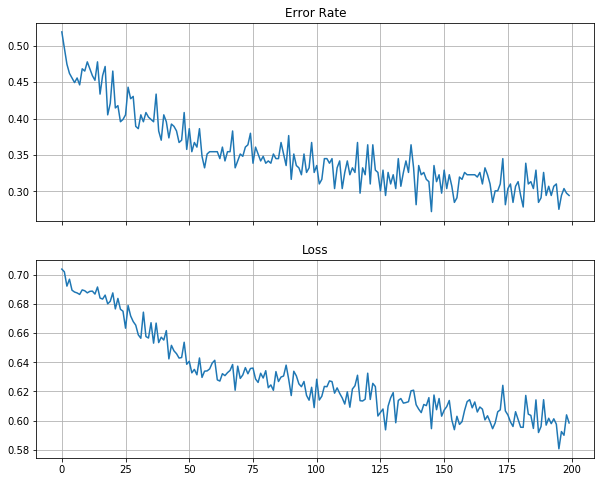

Correct: 52.00%


In [21]:
model = RNN()

errors, losses = train_model(model, train_input, train_target)

fig, ax = plt.subplots(2, 1, figsize=(10,8), sharex=True)
ax[0].plot(np.array(errors)/train_input.size(0))
ax[0].set_title("Error Rate")
ax[0].grid()
ax[1].plot(np.array(losses))
ax[1].set_title("Loss")
ax[1].grid()
plt.show();

nb_error = compute_nb_errors(model, test_input, test_target)
print('Correct: {:.2%}'.format(1-nb_error/test_input.size(0)))